# Cluster profiles based on environmental vertical profiles
- method:
    - create a tensor (Profiles, depths, variables) - (5613, 40, 10)
    - standardize each variable per profile across depths 
    - fit parafac (tensorly.decomposition) with 10 components
    - use k-means clustering to create 10 clusters using the 10 components (each component represents a specific pattern of environmental variables)

In [1]:
import pandas as pd
env_df = pd.read_pickle("../../Data/environmental_profiles_interpolated_cleaned.pkl")
print("Unique Profile IDs:", env_df['Profile_id'].nunique())

env_df.head()

Unique Profile IDs: 5613


,Profile_id,Latitude,Longitude,datetime,depth,ph,chl,no3,po4,si,o2,fe,phyc,thetao_mean,so_mean
0,s033,-75.271,-147.1265,2018-04-02 12:32:55,12.5,8.052681,0.286524,27.321437,1.931307,58.010319,358.297763,0.000496,0.810907,-1.709023,33.419546
1,s033,-75.271,-147.1265,2018-04-02 12:32:55,37.5,8.048817,0.283487,27.473729,1.939934,58.517991,356.938582,0.000464,0.801888,-1.687545,33.464393
2,s033,-75.271,-147.1265,2018-04-02 12:32:55,62.5,8.044707,0.268687,27.622603,1.948238,59.030326,354.834945,0.000446,0.762714,-1.556857,33.528134
3,s033,-75.271,-147.1265,2018-04-02 12:32:55,87.5,8.039586,0.239081,27.747172,1.955313,59.765204,351.631837,0.000458,0.685054,-1.177886,33.693331
4,s033,-75.271,-147.1265,2018-04-02 12:32:55,112.5,8.031029,0.197862,28.056608,1.973801,61.561174,345.278279,0.000490,0.573443,-0.747218,33.943854


In [2]:
# cell: build tensor (Profile x Depth x Variable)
import numpy as np

# replace with your DataFrame name if different
df = env_df

# exclude metadata columns
exclude = {'Profile_id', 'Latitude', 'Longitude', 'datetime', 'depth'}
var_names = [c for c in df.columns if c not in exclude]
print("Variables included:", var_names)

# ordered depth levels and ordered profile ids (preserve appearance order)
depth_levels = np.sort(df['depth'].unique())
profile_ids = df['Profile_id'].unique()

n_profiles = len(profile_ids)
n_depths = len(depth_levels)
n_vars = len(var_names)
print("Profiles, depths, vars:", n_profiles, n_depths, n_vars)

# initialize tensor (use NaN as default so missing cells stand out if any)
tensor = np.full((n_profiles, n_depths, n_vars), np.nan, dtype=np.float32)

# mapping to ensure consistent ordering
depth_to_idx = {d:i for i,d in enumerate(depth_levels)}
profile_to_idx = {p:i for i,p in enumerate(profile_ids)}

# fill tensor by pivoting each variable (fast and clear)
for v_idx, var in enumerate(var_names):
    pivot = df.pivot(index='Profile_id', columns='depth', values=var)
    # ensure same ordering of rows and columns
    pivot = pivot.reindex(index=profile_ids, columns=depth_levels)
    tensor[:, :, v_idx] = pivot.values.astype(np.float32)

# optional: if you prefer zeros instead of NaN for missing entries uncomment:
# tensor = np.nan_to_num(tensor, nan=0.0)

# outputs you can use later
# tensor -> numpy array (n_profiles, n_depths, n_vars)
# profile_ids -> array/list mapping tensor row -> Profile_id
# depth_levels -> array mapping tensor column index -> depth
# var_names -> mapping tensor third-dim index -> variable name

print("Tensor built:", tensor.shape)

Variables included: ['ph', 'chl', 'no3', 'po4', 'si', 'o2', 'fe', 'phyc', 'thetao_mean', 'so_mean']
Profiles, depths, vars: 5613 40 10
Tensor built: (5613, 40, 10)


In [3]:
import tensorflow as tf
import tensorly as tl
print("tensorflow:", tf.__version__)
# Set TensorLy backend to tensorflow (if available)
try:
    tl.set_backend('tensorflow')
except Exception as e:
    print("Could not set TensorLy backend to tensorflow:", e)
print("tensorly backend:", tl.get_backend())

tensorflow: 2.20.0
tensorly backend: tensorflow


In [4]:
# Cell 1: imports, helpers, configuration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorly as tl
from tensorly.decomposition import parafac
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from scipy.signal import savgol_filter

# configuration
RSEED = 42
np.random.seed(RSEED)

# Helper: robust cp -> dense numpy converter and extractor for weights/factors
def cp_to_dense_numpy(cp_result):
    """
    Accepts parafac output (either (weights, factors) tuple or CPTensor-like object)
    Returns: dense numpy array (n_profiles, n_depths, n_vars)
    """
    # try to extract weights/factors
    if hasattr(cp_result, 'weights') and hasattr(cp_result, 'factors'):
        weights = cp_result.weights
        factors = cp_result.factors
    elif isinstance(cp_result, tuple) and len(cp_result) == 2:
        weights, factors = cp_result
    else:
        raise ValueError("Unexpected cp_result format from parafac")

    # try to use tensorly kruskal->tensor implementations
    try:
        from tensorly.kruskal_tensor import kruskal_to_tensor
    except Exception:
        try:
            from tensorly.cp_tensor import cp_to_tensor as kruskal_to_tensor
        except Exception:
            # fallback: build dense with numpy einsum
            weights_np = np.array(weights)
            factors_np = [np.array(f) for f in factors]
            A, B, C = factors_np
            rec = np.zeros((A.shape[0], B.shape[0], C.shape[0]), dtype=np.float32)
            for r in range(A.shape[1]):
                rec += weights_np[r] * np.einsum('i,j,k->ijk', A[:, r], B[:, r], C[:, r])
            return rec

    dense = kruskal_to_tensor((weights, factors))
    try:
        dense_np = tl.to_numpy(dense)
    except Exception:
        dense_np = np.array(dense)
    return dense_np

def cp_extract_weights_factors(cp_result):
    """Return (weights_np, factors_list_of_numpy_arrays)"""
    if hasattr(cp_result, 'weights') and hasattr(cp_result, 'factors'):
        weights = cp_result.weights
        factors = cp_result.factors
    elif isinstance(cp_result, tuple) and len(cp_result) == 2:
        weights, factors = cp_result
    else:
        raise ValueError("Unexpected cp_result format from parafac")
    # convert to numpy
    weights_np = tl.to_numpy(weights) if not isinstance(weights, np.ndarray) else np.array(weights)
    factors_np = [tl.to_numpy(f) if not isinstance(f, np.ndarray) else np.array(f) for f in factors]
    return weights_np, factors_np

print("TensorLy backend:", tl.get_backend())

TensorLy backend: tensorflow


### standardize environmental data
- "per_profile" - each variable is standardized per variable and profile (patterns only)
- "per_variable" - each variable is standardized across all profiles (magnitude differences)

In [5]:
# Cell 2: optional per-variable standardization across (profiles x depths)
# Set standardize=True to standardize each variable (recommended)
standardize = 'per_profile'  # options: None, 'per_variable', 'per_profile'

# verify required variables exist
assert 'tensor' in globals(), "Please load/construct `tensor` first."
assert 'profile_ids' in globals(), "profile_ids missing."
assert 'depth_levels' in globals(), "depth_levels missing."
assert 'var_names' in globals(), "var_names missing."

n_profiles, n_depths, n_vars = tensor.shape
print("tensor shape:", tensor.shape)


tensor shape: (5613, 40, 10)


In [6]:
import numpy as np
import tensorly as tl

def standardize_tensor_per_variable_and_profile(tensor):
    """
    Per-profile standardization.
    Standardize each variable for each individual profile over depths.
    Input: tensor of shape (n_profiles, n_depths, n_vars)
    Output: tensorly tensor of same shape (float32) standardized per-profile
    """
    # copy to avoid overwriting original
    X = np.array(tensor, dtype=np.float32)

    # compute per-profile mean and std along the depth axis (axis=1)
    # shapes: (n_profiles, 1, n_vars)
    means = np.nanmean(X, axis=1, keepdims=True)
    stds  = np.nanstd(X, axis=1, keepdims=True)

    # avoid division by zero: if std == 0 (constant across depths), set std to 1 (no scaling)
    zero_mask = (stds == 0) | np.isnan(stds)
    stds[zero_mask] = 1.0

    # standardize per profile, per variable across depths
    tensor_perprofile_scaled = (X - means) / stds

    # tensor_perprofile_scaled is shape (n_profiles, n_depths, n_vars)
    # If you prefer float32 explicitly:
    tensor_perprofile_scaled = tensor_perprofile_scaled.astype(np.float32)

    # Convert to tensorly tensor (backend may be tensorflow)
    tl_tensor = tl.tensor(tensor_perprofile_scaled)
    print("Per-profile standardization done. Shape:", tensor_perprofile_scaled.shape)
    return tl_tensor


def standardize_tensor_per_variable(tensor):
    """
    Global per-variable standardization.
    Standardize each variable across all profiles and depths.
    Input: tensor of shape (n_profiles, n_depths, n_vars)
    Output: tensorly tensor of same shape (float32) standardized per-variable globally
    """
    # copy to avoid overwriting original
    X = np.array(tensor, dtype=np.float32)

    # compute per-variable mean and std across profiles and depths (axes 0 and 1)
    # shapes: (1, 1, n_vars)
    means = np.nanmean(X, axis=(0, 1), keepdims=True)
    stds  = np.nanstd(X, axis=(0, 1), keepdims=True)

    # avoid division by zero: if std == 0 (constant), set std to 1 (no scaling)
    zero_mask = (stds == 0) | np.isnan(stds)
    stds[zero_mask] = 1.0

    # standardize per variable across all profiles and depths
    tensor_pervariable_scaled = (X - means) / stds

    # ensure float32
    tensor_pervariable_scaled = tensor_pervariable_scaled.astype(np.float32)

    # Convert to tensorly tensor
    tl_tensor = tl.tensor(tensor_pervariable_scaled)
    print("Per-variable (global) standardization done. Shape:", tensor_pervariable_scaled.shape)
    return tl_tensor


# Apply standardization per variable (global) or per variable and profile
tl_tensor = standardize_tensor_per_variable_and_profile(tensor) if standardize == 'per_profile' else None
tl_tensor = standardize_tensor_per_variable(tensor) if standardize == 'per_variable' else tl_tensor

Per-profile standardization done. Shape: (5613, 40, 10)


In [7]:
# Cell 3: fit parafac for several ranks, multiple inits, keep best
ranks_to_try = [4, 6, 8, 10]     # adjust as desired
n_inits = 3                  # random starts per rank

best_results = {}
for rank in ranks_to_try:
    best_rel_err = np.inf
    best_cp = None
    print(f"\nFitting CP rank={rank} (n_inits={n_inits}) ...")
    for init_i in range(n_inits):
        try:
            # init='svd' sometimes more stable, but use 'random' for variety
            cp_res = parafac(tl_tensor, rank=rank, n_iter_max=400, init='random', tol=1e-6, random_state=RSEED+init_i, verbose=False)
            dense_np = cp_to_dense_numpy(cp_res)
            orig_np = tl.to_numpy(tl_tensor)
            rel_err = np.linalg.norm(orig_np - dense_np) / np.linalg.norm(orig_np)
            rmse = np.sqrt(mean_squared_error(orig_np.ravel(), dense_np.ravel()))
            print(f" init {init_i}: rel_err={rel_err:.6e}, RMSE={rmse:.6e}")
            if rel_err < best_rel_err:
                best_rel_err = rel_err
                best_cp = cp_res
        except Exception as e:
            print("  init", init_i, "failed:", str(e))
    if best_cp is None:
        raise RuntimeError(f"No successful CP fit for rank {rank}")
    best_results[rank] = {'cp': best_cp, 'rel_err': best_rel_err}
    print(f" Best rel_err for rank {rank}: {best_rel_err:.6e}")

# choose rank with lowest relative error by default
rank_selected = min(best_results.keys(), key=lambda r: best_results[r]['rel_err'])
print("\nSelected rank:", rank_selected, "rel_err:", best_results[rank_selected]['rel_err'])
cp_best = best_results[rank_selected]['cp']
dense_best = cp_to_dense_numpy(cp_best)


Fitting CP rank=4 (n_inits=3) ...
 init 0: rel_err=4.155919e-01, RMSE=4.155919e-01
 init 1: rel_err=4.150730e-01, RMSE=4.150731e-01
 init 2: rel_err=4.151438e-01, RMSE=4.151439e-01
 Best rel_err for rank 4: 4.150730e-01

Fitting CP rank=6 (n_inits=3) ...
 init 0: rel_err=3.509005e-01, RMSE=3.509005e-01
 init 1: rel_err=3.528206e-01, RMSE=3.528207e-01
 init 2: rel_err=3.563595e-01, RMSE=3.563595e-01
 Best rel_err for rank 6: 3.509005e-01

Fitting CP rank=8 (n_inits=3) ...
 init 0: rel_err=3.138763e-01, RMSE=3.138764e-01
 init 1: rel_err=3.161775e-01, RMSE=3.161775e-01
 init 2: rel_err=3.142256e-01, RMSE=3.142257e-01
 Best rel_err for rank 8: 3.138763e-01

Fitting CP rank=10 (n_inits=3) ...
 init 0: rel_err=2.793408e-01, RMSE=2.793408e-01
 init 1: rel_err=2.829624e-01, RMSE=2.829625e-01
 init 2: rel_err=2.798226e-01, RMSE=2.798226e-01
 Best rel_err for rank 10: 2.793408e-01

Selected rank: 10 rel_err: 0.27934077


In [8]:
# Example: run several parafac fits and store A matrices (profiles x R) in list_As
from tensorly.decomposition import parafac
import numpy as np

rank = 10
n_runs = 5
list_As = []
for i in range(n_runs):
    cp_res = parafac(tl_tensor, rank=rank, n_iter_max=400, init='random', tol=1e-6, random_state=RSEED+i, verbose=False)
    weights, factors = cp_res if isinstance(cp_res, tuple) else (cp_res.weights, cp_res.factors)
    A_run = tl.to_numpy(factors[0])   # profiles x R
    list_As.append(A_run)

# function to compute best greedy matching correlation between two A matrices
def match_corr(A_ref, A_other):
    R = A_ref.shape[1]
    corr = np.zeros((R,R))
    for i in range(R):
        for j in range(R):
            a = A_ref[:,i]; b = A_other[:,j]
            # if constant vectors appear, handle zero-std
            if np.std(a)==0 or np.std(b)==0:
                corr[i,j] = 0.0
            else:
                corr[i,j] = np.corrcoef(a,b)[0,1]
    # greedy matching
    corr_abs = np.abs(corr)
    matched = []
    total = 0.0
    for _ in range(R):
        i,j = np.unravel_index(np.argmax(corr_abs), corr_abs.shape)
        matched.append((i,j,corr[i,j]))
        total += abs(corr[i,j])
        corr_abs[i,:] = -1; corr_abs[:,j] = -1
    mean_abs_corr = total / R
    return matched, mean_abs_corr, corr

# pairwise summary
for i in range(len(list_As)):
    for j in range(i+1, len(list_As)):
        _, mean_corr, _ = match_corr(list_As[i], list_As[j])
        print(f"mean abs corr between run {i} and {j}: {mean_corr:.3f}")

mean abs corr between run 0 and 1: 0.601
mean abs corr between run 0 and 2: 0.585
mean abs corr between run 0 and 3: 0.636
mean abs corr between run 0 and 4: 0.715
mean abs corr between run 1 and 2: 0.681
mean abs corr between run 1 and 3: 0.599
mean abs corr between run 1 and 4: 0.670
mean abs corr between run 2 and 3: 0.646
mean abs corr between run 2 and 4: 0.664
mean abs corr between run 3 and 4: 0.721


Component count R = 10
A shape (profiles x R): (5613, 10)
B shape (depth x R): (40, 10)
C shape (vars x R): (10, 10)


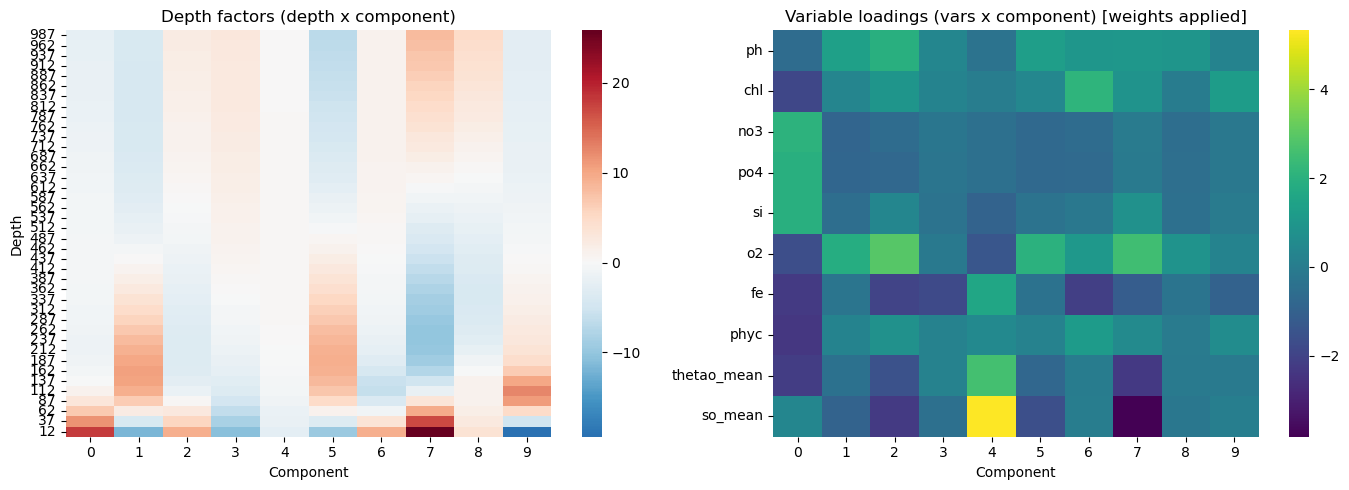

C:\Users\bthobor\AppData\Local\Temp\ipykernel_31796\347821332.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(var_names, rotation=45, ha='right')


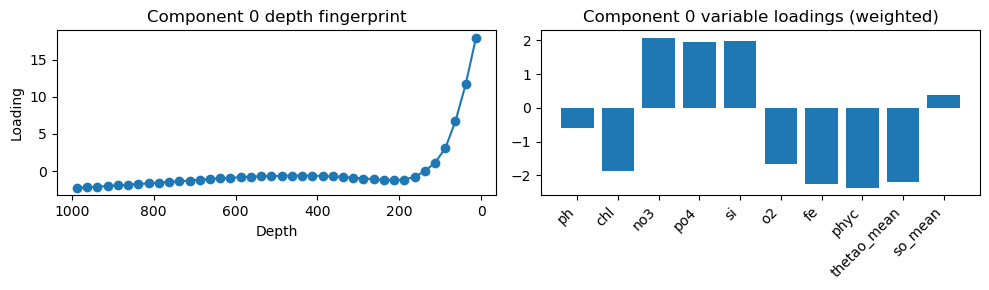

C:\Users\bthobor\AppData\Local\Temp\ipykernel_31796\347821332.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(var_names, rotation=45, ha='right')


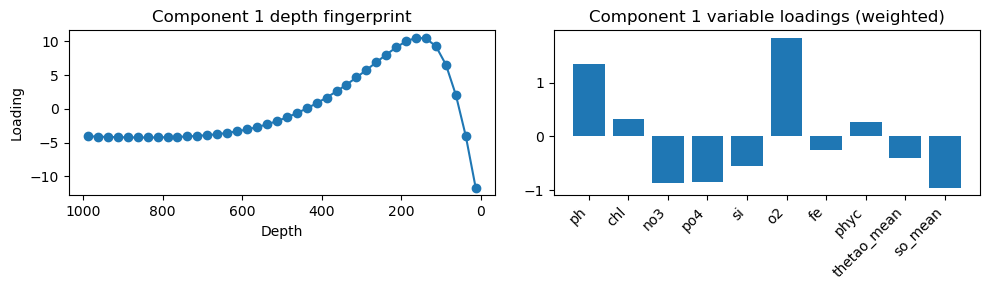

C:\Users\bthobor\AppData\Local\Temp\ipykernel_31796\347821332.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(var_names, rotation=45, ha='right')


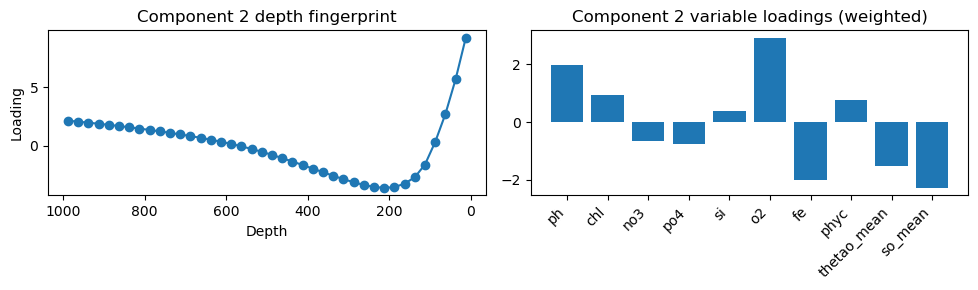

C:\Users\bthobor\AppData\Local\Temp\ipykernel_31796\347821332.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(var_names, rotation=45, ha='right')


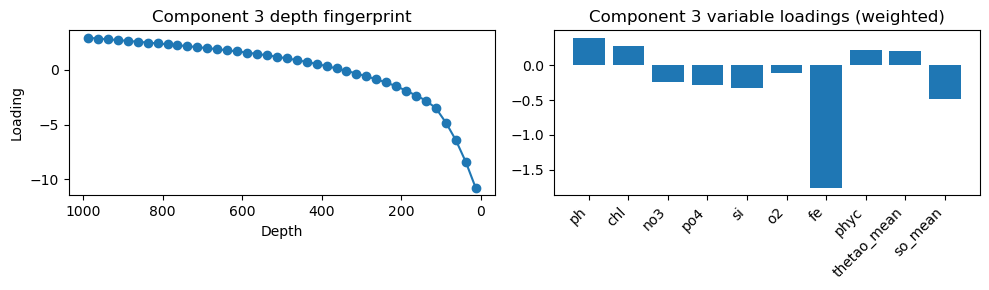

C:\Users\bthobor\AppData\Local\Temp\ipykernel_31796\347821332.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(var_names, rotation=45, ha='right')


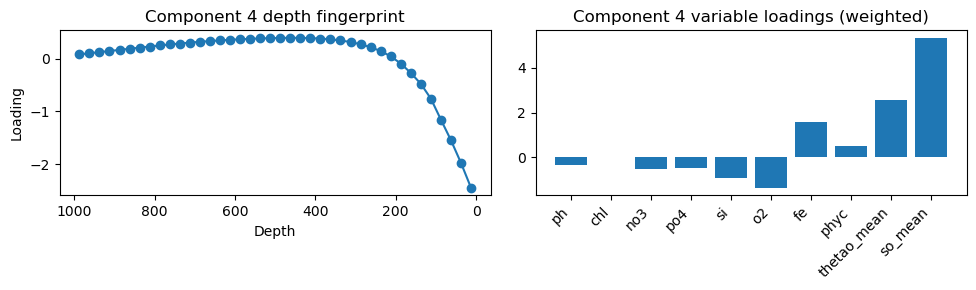

C:\Users\bthobor\AppData\Local\Temp\ipykernel_31796\347821332.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(var_names, rotation=45, ha='right')


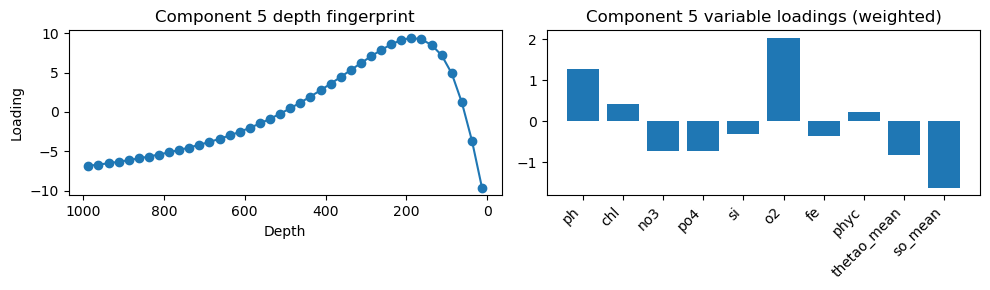

C:\Users\bthobor\AppData\Local\Temp\ipykernel_31796\347821332.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(var_names, rotation=45, ha='right')


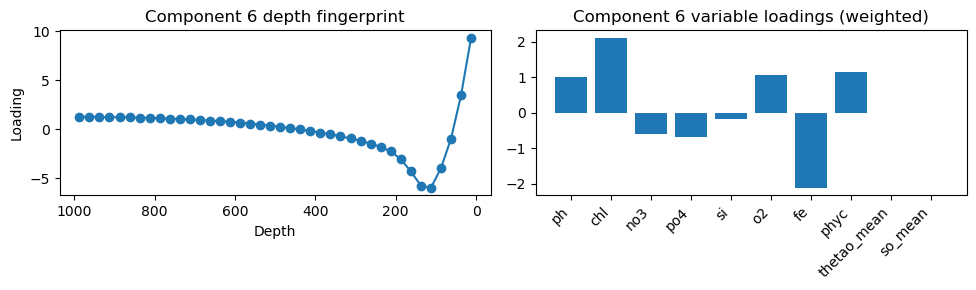

C:\Users\bthobor\AppData\Local\Temp\ipykernel_31796\347821332.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(var_names, rotation=45, ha='right')


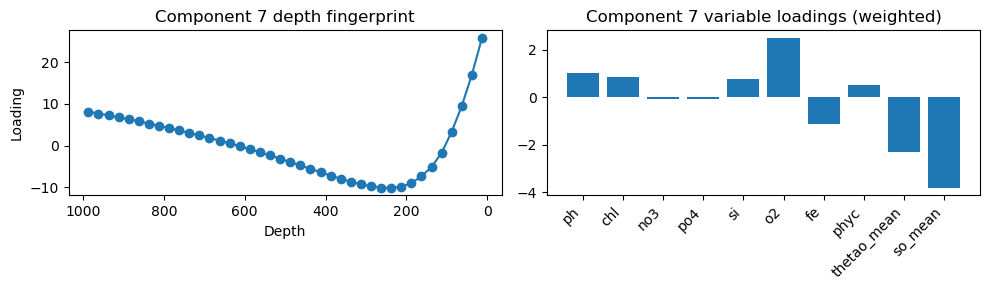

C:\Users\bthobor\AppData\Local\Temp\ipykernel_31796\347821332.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(var_names, rotation=45, ha='right')


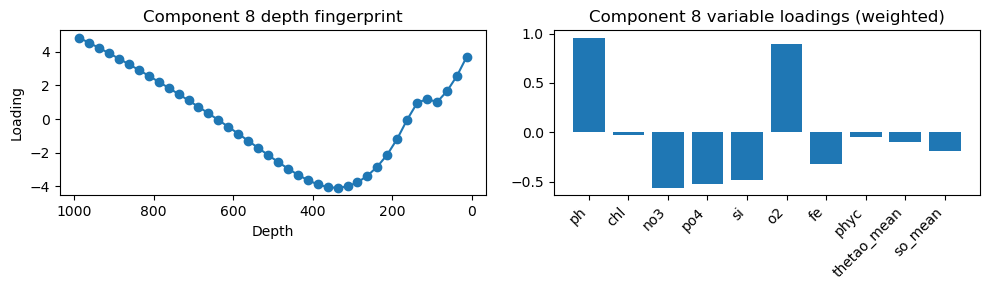

C:\Users\bthobor\AppData\Local\Temp\ipykernel_31796\347821332.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(var_names, rotation=45, ha='right')


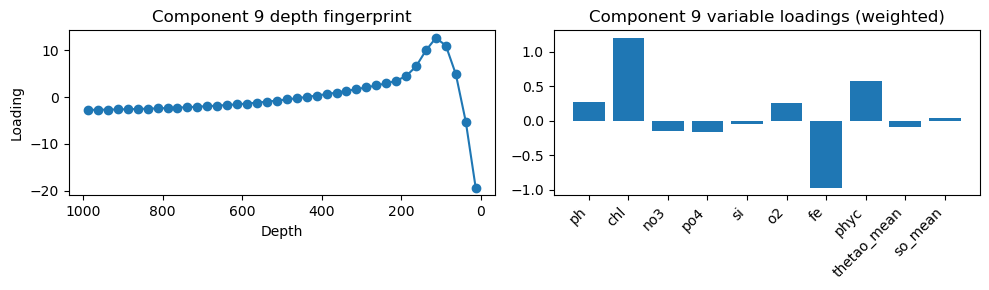

In [9]:
# Cell 4: extract weights & factors, prepare A (profiles x R), B (depth x R), C (vars x R)
weights_np, factors_np = cp_extract_weights_factors(cp_best)
A = factors_np[0]   # profiles x R
B = factors_np[1]   # depths x R
C = factors_np[2]   # vars x R
R = A.shape[1]

# absorb weights into one factor (for interpretation) - multiply C by weights
C_weighted = C * weights_np[np.newaxis, :]

print("Component count R =", R)
print("A shape (profiles x R):", A.shape)
print("B shape (depth x R):", B.shape)
print("C shape (vars x R):", C.shape)

# Lightly smooth depth factors for plotting if many depth bins
B_plot = B.copy()
if n_depths >= 7:
    win = 7 if n_depths >= 7 else (n_depths // 2) * 2 + 1
    for r in range(R):
        try:
            B_plot[:, r] = savgol_filter(B[:, r], window_length=win, polyorder=2)
        except Exception:
            B_plot[:, r] = B[:, r]

# Plot heatmaps: depth factors and variable loadings
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14,5))
sns.heatmap(B_plot, cmap='RdBu_r', center=0, yticklabels=[str(int(d)) for d in depth_levels], ax=ax0)
ax0.set_title('Depth factors (depth x component)')
ax0.set_ylabel('Depth'); ax0.set_xlabel('Component')
ax0.invert_yaxis()

sns.heatmap(C_weighted, cmap='viridis', yticklabels=var_names, ax=ax1)
ax1.set_title('Variable loadings (vars x component) [weights applied]')
ax1.set_xlabel('Component')
plt.tight_layout()
plt.show()

# Plot per-component depth trace + variable bar for quick inspection
for r in range(R):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,3))
    ax1.plot(depth_levels, B_plot[:, r], '-o')
    ax1.set_title(f'Component {r} depth fingerprint'); ax1.invert_xaxis()
    ax1.set_xlabel('Depth'); ax1.set_ylabel('Loading')
    ax2.bar(var_names, C_weighted[:, r])
    ax2.set_title(f'Component {r} variable loadings (weighted)')
    ax2.set_xticklabels(var_names, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

Cluster counts:
 cluster
1    1072
8     883
9     654
6     606
3     590
2     452
5     411
0     367
4     319
7     259
Name: count, dtype: int64
Component 0 top variables (abs weighted): [('phyc', -2.369284152984619), ('fe', -2.250312566757202), ('thetao_mean', -2.186281442642212), ('no3', 2.070580005645752), ('si', 1.964719533920288), ('po4', 1.9579877853393555)]
Component 1 top variables (abs weighted): [('o2', 1.838758111000061), ('ph', 1.3538272380828857), ('so_mean', -0.9603198170661926), ('no3', -0.8673446774482727), ('po4', -0.8528236150741577), ('si', -0.5459049344062805)]
Component 2 top variables (abs weighted): [('o2', 2.908829927444458), ('so_mean', -2.272754430770874), ('fe', -1.9900304079055786), ('ph', 1.9645601511001587), ('thetao_mean', -1.514691948890686), ('chl', 0.9511585235595703)]
Component 3 top variables (abs weighted): [('fe', -1.7581700086593628), ('so_mean', -0.48308730125427246), ('ph', 0.39130717515945435), ('si', -0.3325802981853485), ('po4', -0.2785

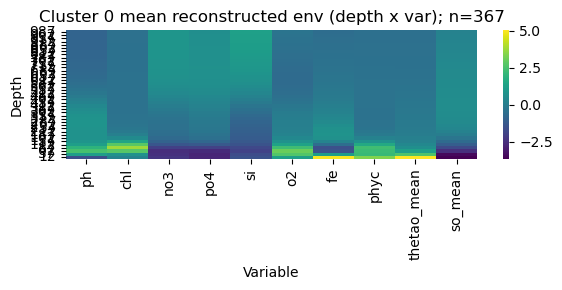

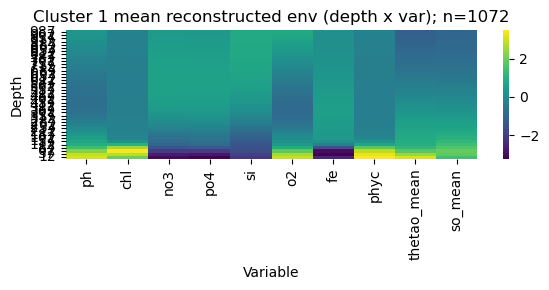

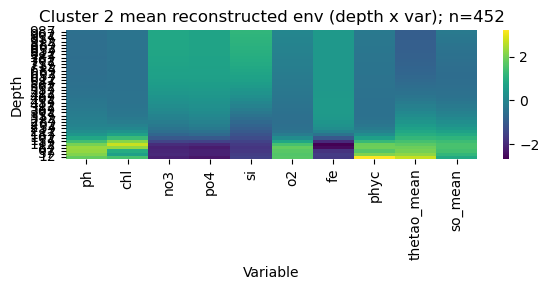

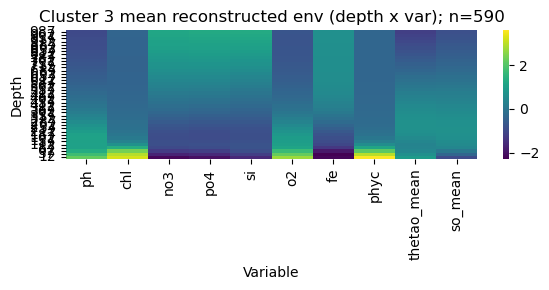

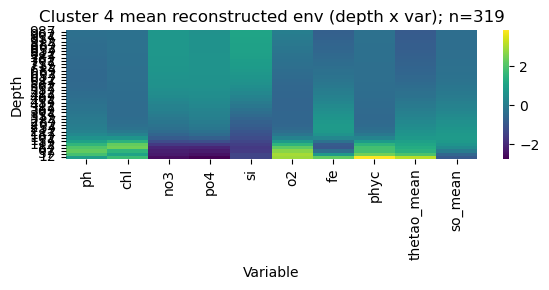

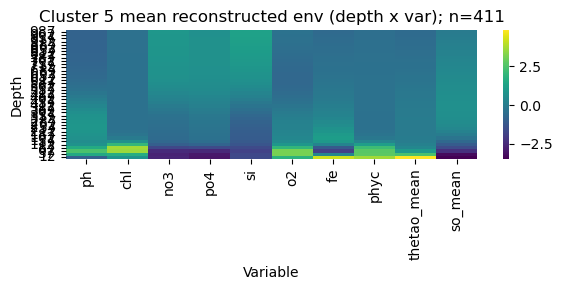

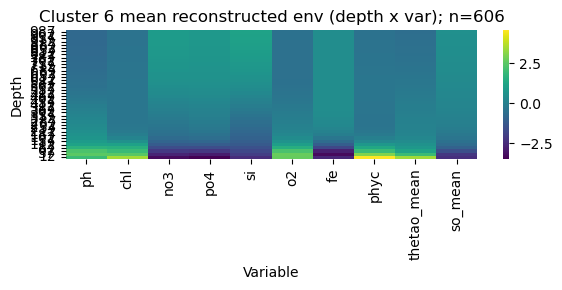

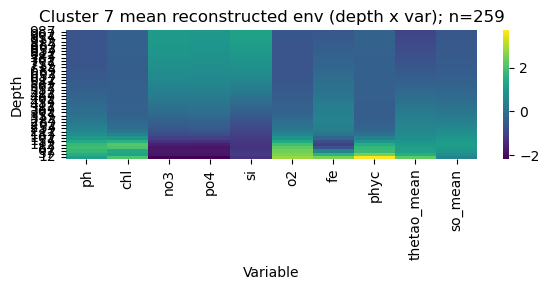

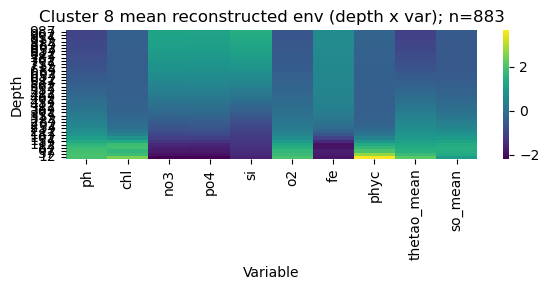

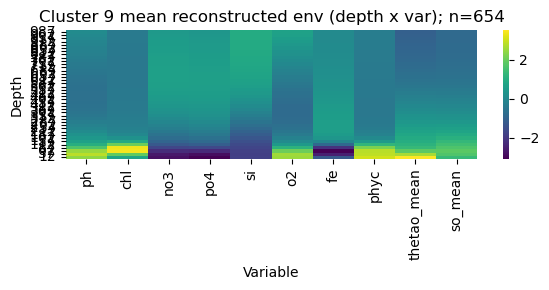

In [18]:
# Cell 5: cluster profile loadings and save results
# Standardize A across components
scalerA = StandardScaler().fit(A)
A_scaled = scalerA.transform(A)

# KMeans clustering on profile loadings
k = min(R+1, 10)   # default choice, tweak as desired
km = KMeans(n_clusters=k, random_state=RSEED).fit(A_scaled)
labels = km.labels_

# Create DataFrame with loadings and cluster labels
df_loadings = pd.DataFrame(A, index=profile_ids, columns=[f'CP_{i+1}' for i in range(R)])
df_loadings['cluster'] = labels
print("Cluster counts:\n", df_loadings['cluster'].value_counts())

# # Save loadings and labels
# df_loadings.to_csv('profile_cp_loadings_and_clusters.csv')
# print("Saved profile_cp_loadings_and_clusters.csv")

# Visualize mean reconstructed env per cluster (depth x var heatmap)
# dense_best holds reconstructed (n_profiles, n_depths, n_vars)
reconstructed = dense_best  # numpy array

for cl in sorted(df_loadings['cluster'].unique()):
    members = df_loadings[df_loadings['cluster'] == cl].index.tolist()
    mask_idx = [list(profile_ids).index(p) for p in members]
    if len(mask_idx) == 0:
        continue
    mean_rec = reconstructed[mask_idx].mean(axis=0)  # depth x var
    plt.figure(figsize=(6,3))
    sns.heatmap(mean_rec, cmap='viridis', xticklabels=var_names, yticklabels=[str(int(d)) for d in depth_levels])
    plt.gca().invert_yaxis()
    plt.title(f'Cluster {cl} mean reconstructed env (depth x var); n={len(mask_idx)}')
    plt.xlabel('Variable'); plt.ylabel('Depth')
    plt.tight_layout()
    #plt.show()

# Brief summary: top variables per component
for r in range(R):
    top_idx = np.argsort(-np.abs(C_weighted[:, r]))[:6]
    top_vars = [(var_names[i], float(C_weighted[i, r])) for i in top_idx]
    print(f"Component {r} top variables (abs weighted):", top_vars)

Using cartopy for map plotting.


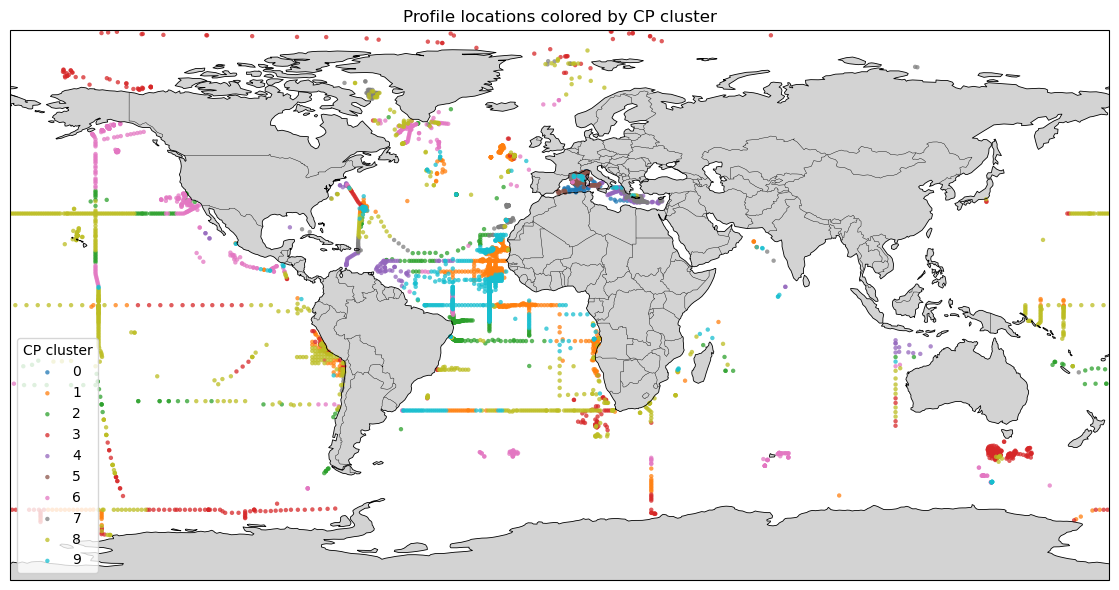

In [17]:
# Plot profiles on global map colored by CP cluster (0..5)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Prepare a merged DataFrame with lat/lon and cluster label ---
# df_loadings: DataFrame with index profile_ids and column 'cluster'
# if df_loadings index is profile_ids, ensure it's a column for merging:
if hasattr(df_loadings, 'index') and 'Profile_id' not in df_loadings.columns:
    df_loadings = df_loadings.reset_index().rename(columns={'index': 'Profile_id'})

# Get one lat/lon per Profile_id from env_df (take first row per profile)
coords = env_df.groupby('Profile_id')[['Latitude', 'Longitude']].first().reset_index()
plot_df = df_loadings.merge(coords, on='Profile_id', how='left')

# Drop any with missing coordinates
n_missing = plot_df['Latitude'].isna().sum() + plot_df['Longitude'].isna().sum()
if n_missing > 0:
    print(f"Warning: {n_missing} profiles missing lat/lon — they will be dropped from the map.")
plot_df = plot_df.dropna(subset=['Latitude', 'Longitude'])

# numeric arrays for plotting
lons = plot_df['Longitude'].values
lats = plot_df['Latitude'].values
labels = plot_df['cluster'].astype(int).values

# color map and plotting parameters
cmap = plt.get_cmap('tab10')   # supports up to 10 distinct colors
unique_labels = np.unique(labels)
colors = {lab: cmap(i % 10) for i, lab in enumerate(unique_labels)}
marker_size = 10
alpha = 0.75

# --- Try cartopy (best) then geopandas then fallback plain scatter ---
use_cartopy = False
use_geopandas = False

try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    use_cartopy = True
except Exception:
    try:
        import geopandas as gpd
        use_geopandas = True
    except Exception:
        pass

if use_cartopy:
    print("Using cartopy for map plotting.")
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
    ax.set_global()
    ax.coastlines(resolution='110m', linewidth=0.6)
    ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3, zorder=0)

    # scatter points colored by cluster
    for lab in unique_labels:
        mask = labels == lab
        ax.scatter(lons[mask], lats[mask], s=marker_size, c=[colors[lab]], label=str(lab),
                   transform=ccrs.PlateCarree(), alpha=alpha, edgecolors='none')
    ax.legend(title='CP cluster', loc='lower left')
    ax.set_title('Profile locations colored by CP cluster')
    plt.tight_layout()
    plt.show()

elif use_geopandas:
    print("Using GeoPandas (Natural Earth) for map plotting.")
    import geopandas as gpd
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # build GeoDataFrame for points
    gdf_points = gpd.GeoDataFrame(plot_df, geometry=gpd.points_from_xy(plot_df['Longitude'], plot_df['Latitude']), crs="EPSG:4326")
    fig, ax = plt.subplots(1, 1, figsize=(12,6))
    world.plot(ax=ax, color='lightgray', edgecolor='white')
    for lab in unique_labels:
        subset = gdf_points[gdf_points['cluster'] == lab]
        subset.plot(ax=ax, markersize=marker_size, color=colors[lab], label=str(lab), alpha=alpha)
    ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
    ax.set_title('Profile locations colored by CP cluster')
    ax.legend(title='CP cluster', loc='lower left')
    plt.tight_layout()
    plt.show()

else:
    # fallback: simple lon/lat scatter (no coastlines)
    print("Mapping libraries not found. Falling back to simple lon/lat scatter (no coastlines).")
    fig, ax = plt.subplots(figsize=(12,6))
    for lab in unique_labels:
        mask = labels == lab
        ax.scatter(lons[mask], lats[mask], s=marker_size, c=[colors[lab]], label=str(lab), alpha=alpha, edgecolors='none')
    ax.set_xlim(-180, 180); ax.set_ylim(-90, 90)
    ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
    ax.set_title('Profile locations colored by CP cluster (lon/lat scatter)')
    ax.legend(title='CP cluster', loc='lower left')
    plt.grid(True, linestyle=':', linewidth=0.3)
    plt.tight_layout()
    plt.show()

# --- Optional: save figure ---
# outfile = 'profiles_by_cp_cluster.png'
# fig.savefig(outfile, dpi=200)
# print("Saved map to", outfile)

In [12]:
# Cell 1: prepare data (df_loadings expected, fallback to A/A_scaled)
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Use df_loadings if present
if 'df_loadings' in globals():
    df = df_loadings.copy()
    # ensure CP columns exist
    cp_cols = [c for c in df.columns if c.startswith('CP_')]
    assert len(cp_cols) > 0, "df_loadings has no CP_ columns"
    X = df[cp_cols].values          # raw loadings
    labels = df['cluster'].values
    profile_idx = df.index.values
else:
    # fallback to A / A_scaled if available
    assert 'A' in globals(), "No df_loadings or A found. Run CP step first."
    X = A.copy()
    # standardize A
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)
    labels = None
    if 'profile_ids' in globals():
        profile_idx = np.array(profile_ids)
    else:
        profile_idx = np.arange(X.shape[0])
    if 'labels' in globals():
        labels = labels
    else:
        raise AssertionError("No cluster labels found: ensure df_loadings['cluster'] exists or create `labels` array.")

# compute centroids (mean of loadings per cluster)
unique_labels = np.unique(labels)
centroids = np.vstack([X[labels == lab].mean(axis=0) for lab in unique_labels])
cluster_sizes = {lab: int((labels == lab).sum()) for lab in unique_labels}
print("Clusters:", unique_labels, "sizes:", cluster_sizes)

Clusters: [0 1 2 3 4 5 6 7 8 9] sizes: {np.int32(0): 367, np.int32(1): 1072, np.int32(2): 452, np.int32(3): 590, np.int32(4): 319, np.int32(5): 411, np.int32(6): 606, np.int32(7): 259, np.int32(8): 883, np.int32(9): 654}


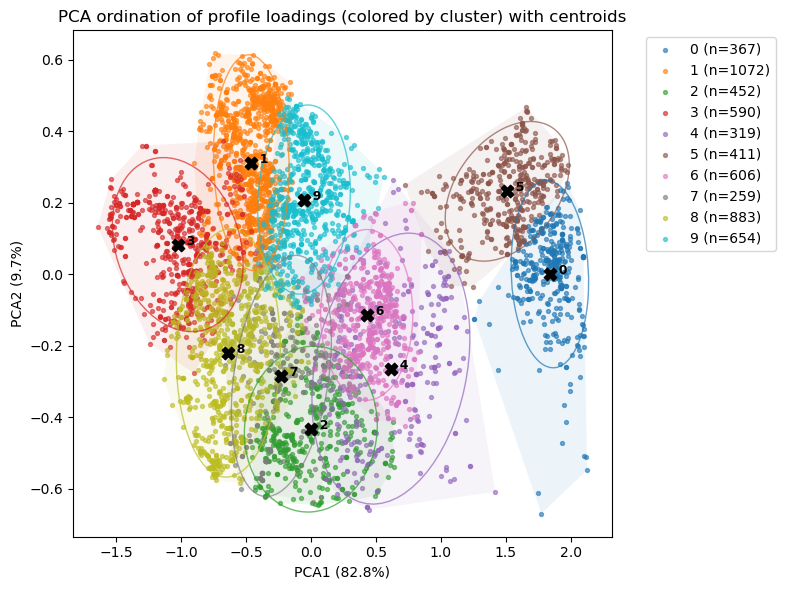

In [13]:
# Cell 2: PCA ordination with centroids + convex hulls and 95% covariance ellipses
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.spatial import ConvexHull

pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(X)            # project profiles
centroids2 = pca.transform(centroids)  # project centroids

# scatter colored by cluster
plt.figure(figsize=(8,6))
palette = sns.color_palette("tab10", n_colors=len(unique_labels))
for i, lab in enumerate(unique_labels):
    mask = labels == lab
    plt.scatter(X2[mask,0], X2[mask,1], s=8, c=[palette[i]], alpha=0.6, label=f"{lab} (n={cluster_sizes[lab]})")

# plot centroid markers
plt.scatter(centroids2[:,0], centroids2[:,1], c='black', s=80, marker='X', zorder=5)
for i, lab in enumerate(unique_labels):
    plt.text(centroids2[i,0], centroids2[i,1], f"  {lab}", fontsize=9, weight='bold')

# convex hulls (skip if cluster has <3 points)
for i, lab in enumerate(unique_labels):
    pts = X2[labels == lab]
    if pts.shape[0] >= 3:
        try:
            hull = ConvexHull(pts)
            hull_pts = pts[hull.vertices]
            plt.fill(hull_pts[:,0], hull_pts[:,1], color=palette[i], alpha=0.08, linewidth=0)
        except Exception:
            pass

# 95% covariance ellipse function
def plot_cov_ellipse(mean, cov, ax, n_std=2.0, facecolor='none', edgecolor='k', **kwargs):
    # n_std ~ 2.4477 for ~95% if 2D normal -> but use n_std param
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:,order]
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    width, height = 2 * n_std * np.sqrt(vals)
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=theta, facecolor=facecolor, edgecolor=edgecolor, **kwargs)
    ax.add_patch(ellipse)

ax = plt.gca()
# add ellipses per cluster
for i, lab in enumerate(unique_labels):
    pts = X2[labels == lab]
    if pts.shape[0] >= 5:
        cov = np.cov(pts.T)
        mean = pts.mean(axis=0)
        plot_cov_ellipse(mean, cov, ax, n_std=2.0, edgecolor=palette[i], alpha=0.7)

plt.xlabel(f"PCA1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PCA2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA ordination of profile loadings (colored by cluster) with centroids")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

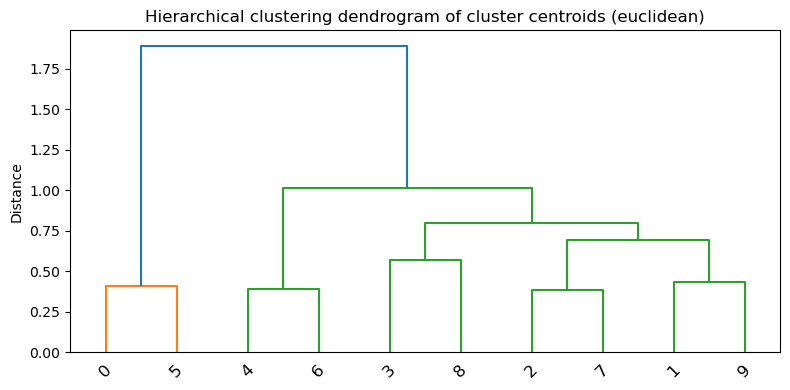

In [14]:
# Cell 3: dendrogram of centroids (hierarchical clustering)
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform

# compute pairwise distances between centroids (Euclidean or use 'cosine')
dist_metric = 'euclidean'
pairwise = pdist(centroids, metric=dist_metric)
link = linkage(pairwise, method='average')  # average/ward/complete/single

plt.figure(figsize=(8,4))
dend = dendrogram(link, labels=[str(l) for l in unique_labels], leaf_rotation=45)
plt.title(f"Hierarchical clustering dendrogram of cluster centroids ({dist_metric})")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

Using variable column order: ['si', 'no3', 'po4', 'fe', 'o2', 'chl', 'phyc', 'ph', 'thetao_mean', 'so_mean']
Display labels: ['si', 'no3', 'po4', 'fe', 'o2', 'chl', 'phyc', 'ph', 'temp', 'sal']


C:\Users\bthobor\AppData\Local\Temp\ipykernel_31796\270179149.py:180: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,1,0.96])


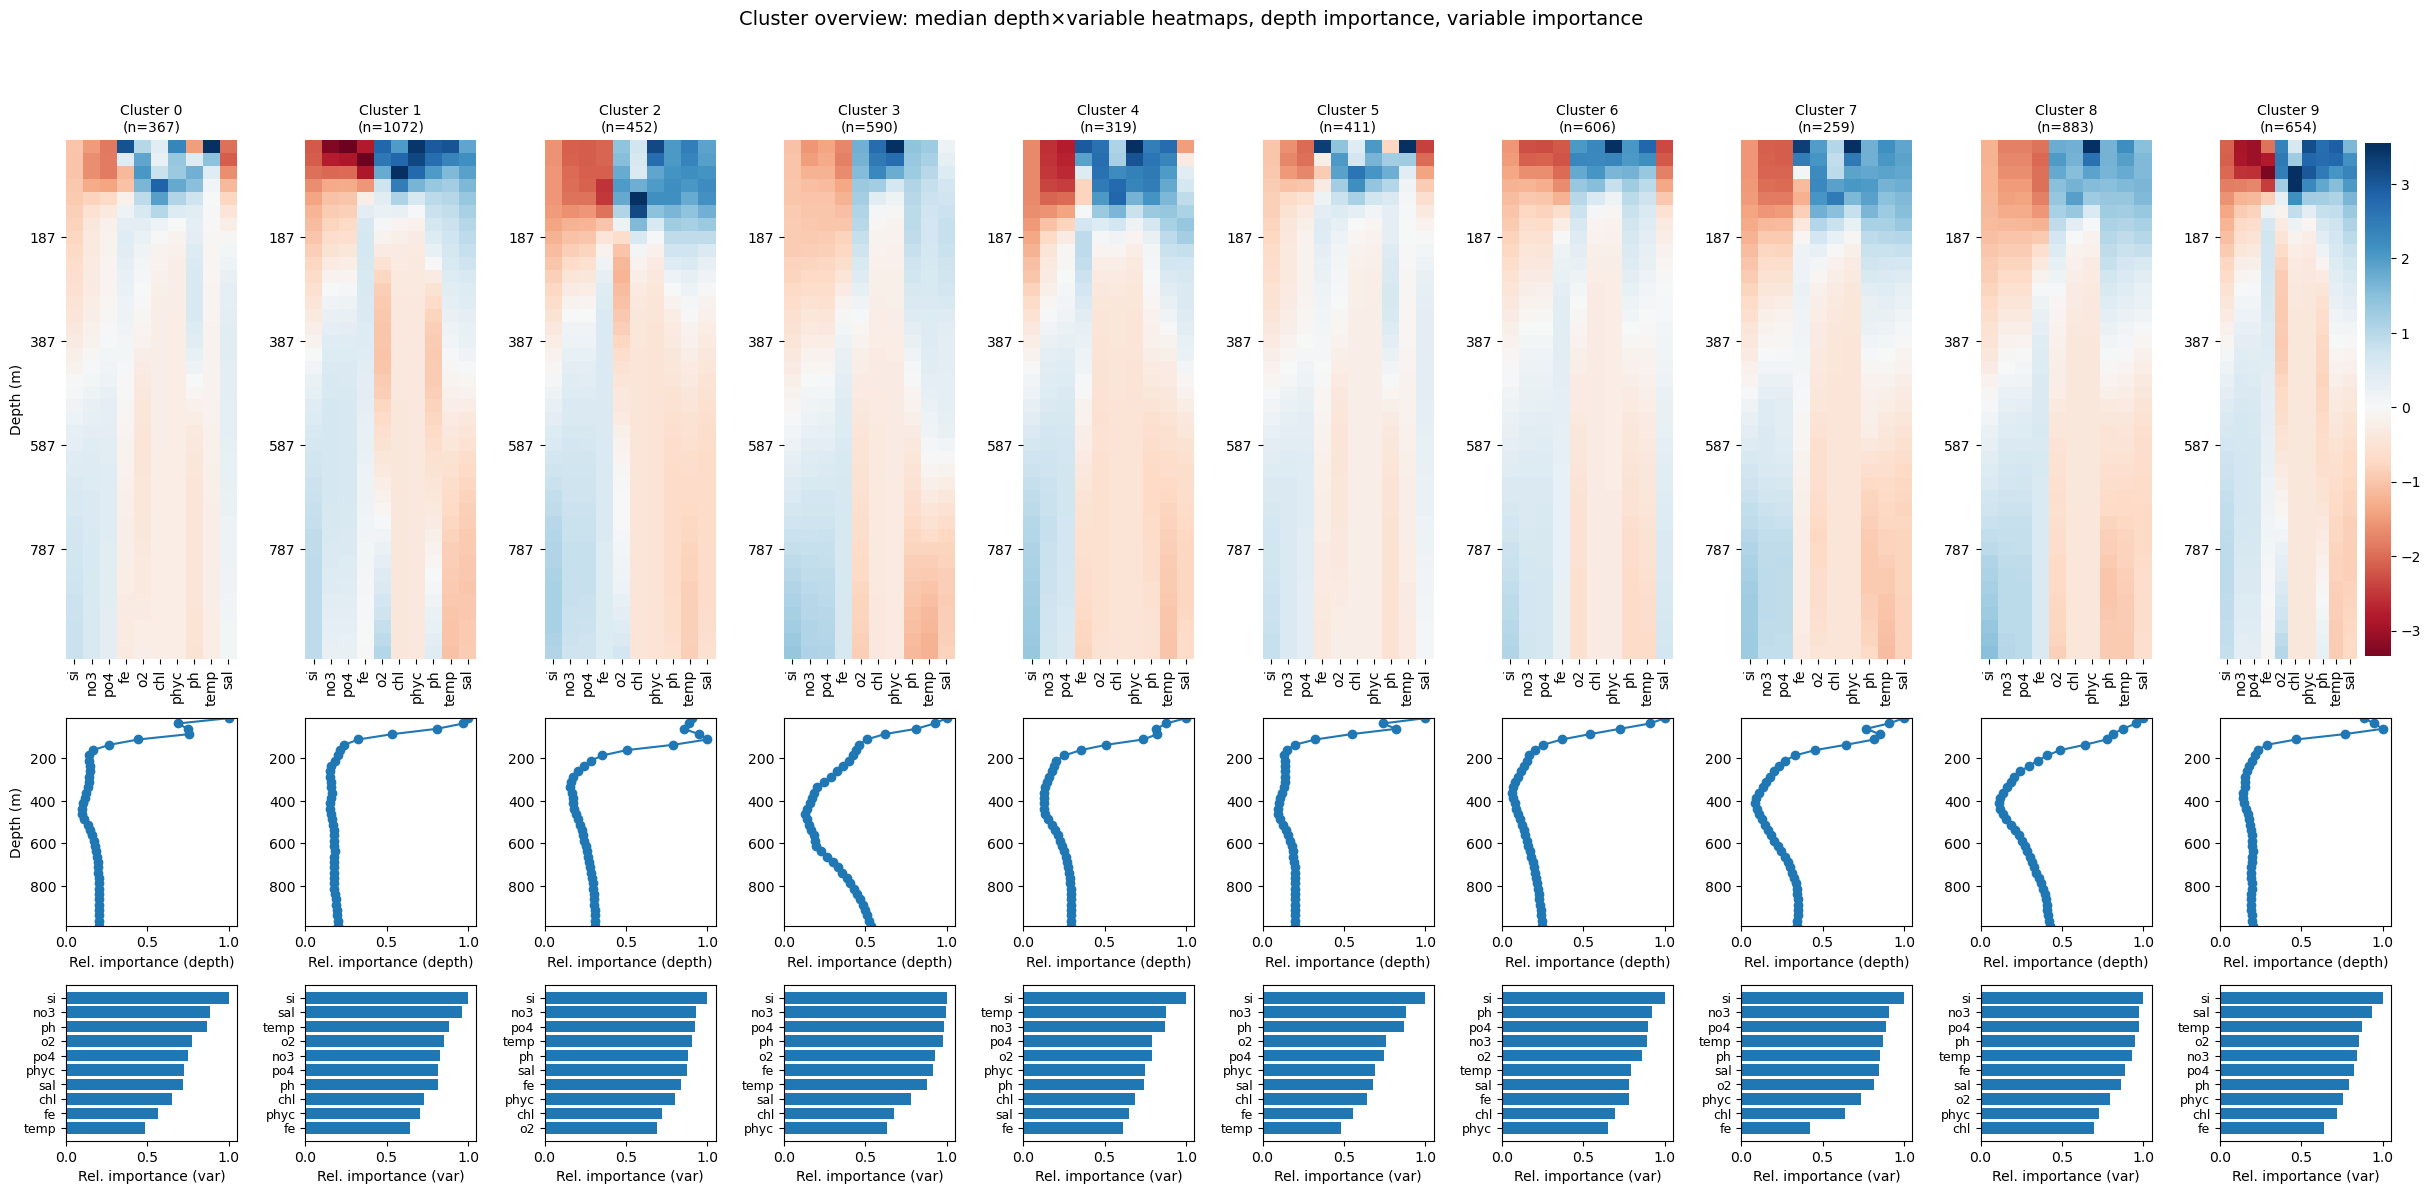

In [15]:
# Updated cluster overview with requested ordering & ticks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Inputs: same assumptions as before ---
assert ('df_loadings' in globals()), "df_loadings with cluster labels is required."

# prepare base tensor and names (reuse previous logic)
if 'tensor' in globals():
    base_tensor = np.array(tensor, dtype=np.float32)
    base_profile_ids = list(profile_ids)
    base_depths = np.array(list(depth_levels), dtype=float)
    base_var_names = list(var_names)
else:
    assert 'env_df' in globals(), "env_df or tensor must exist in workspace."
    exclude = {'Profile_id','Latitude','Longitude','datetime','depth'}
    base_var_names = [c for c in env_df.columns if c not in exclude]
    base_depths = np.sort(env_df['depth'].unique()).astype(float)
    base_profile_ids = env_df['Profile_id'].unique()
    n_profiles = len(base_profile_ids); n_depths = len(base_depths); n_vars = len(base_var_names)
    base_tensor = np.full((n_profiles, n_depths, n_vars), np.nan, dtype=np.float32)
    for v_idx, var in enumerate(base_var_names):
        pivot = env_df.pivot(index='Profile_id', columns='depth', values=var)
        pivot = pivot.reindex(index=base_profile_ids, columns=base_depths)
        base_tensor[:,:,v_idx] = pivot.values.astype(np.float32)

# per-profile standardization (shape-only)
X = base_tensor.copy().astype(np.float32)
means = np.nanmean(X, axis=1, keepdims=True)
stds  = np.nanstd(X, axis=1, keepdims=True)
stds_fixed = stds.copy()
stds_fixed[(stds_fixed == 0) | np.isnan(stds_fixed)] = 1.0
tensor_perprofile_scaled = ((X - means) / stds_fixed).astype(np.float32)

# ensure df_load has Profile_id column
df_load = df_loadings.copy()
if 'Profile_id' not in df_load.columns and df_load.index.name in (None, ''):
    df_load = df_load.reset_index().rename(columns={'index':'Profile_id'})
elif 'Profile_id' not in df_load.columns:
    df_load = df_load.reset_index()

# restrict df_load to profiles present in tensor
profile_id_list = list(base_profile_ids)
pid_to_idx = {p:i for i,p in enumerate(profile_id_list)}
df_load = df_load[df_load['Profile_id'].isin(profile_id_list)].copy()
if df_load.empty:
    raise RuntimeError("No matching Profile_id in df_loadings and your tensor/profile list.")

cluster_labels = sorted(df_load['cluster'].unique())
n_clusters = len(cluster_labels)

# Desired variable order and display names
desired_order = ['si','no3','po4','fe','o2','chl','phyc','ph','thetao_mean','so_mean']
display_name_map = {
    'thetao_mean': 'temp',
    'so_mean': 'sal'
}
# Verify and build final var order that exists in base_var_names
existing_order = [v for v in desired_order if v in base_var_names]
# if any desired var missing, append remaining vars at end to avoid crashes
remaining = [v for v in base_var_names if v not in existing_order]
final_var_order = existing_order + remaining
final_var_labels = [display_name_map.get(v, v) for v in final_var_order]

print("Using variable column order:", final_var_order)
print("Display labels:", final_var_labels)

# compute cluster medians on per-profile standardized values (depth x var)
cluster_medians = {}
cluster_counts = {}
for cl in cluster_labels:
    members = df_load.loc[df_load['cluster'] == cl, 'Profile_id'].values
    indices = [pid_to_idx[p] for p in members if p in pid_to_idx]
    if len(indices) == 0:
        cluster_medians[cl] = np.full((len(base_depths), len(final_var_order)), np.nan)
        cluster_counts[cl] = 0
        continue
    subset = tensor_perprofile_scaled[indices, :, :]   # (n_members, depth, var)
    # reorder variables to final_var_order
    # find indices of final_var_order in base_var_names
    var_idx_map = [base_var_names.index(v) for v in final_var_order]
    subset_reordered = subset[:, :, var_idx_map]      # (members, depth, ordered_vars)
    med = np.nanmedian(subset_reordered, axis=0)     # (depth, ordered_vars)
    cluster_medians[cl] = med
    cluster_counts[cl] = len(indices)

# compute depth & variable importance (normalized)
cluster_depth_importance = {}
cluster_var_importance = {}
for cl in cluster_labels:
    med = cluster_medians[cl]
    depth_imp = np.nanmean(np.abs(med), axis=1)
    if np.nanmax(depth_imp) > 0:
        depth_imp = depth_imp / np.nanmax(depth_imp)
    cluster_depth_importance[cl] = depth_imp
    var_imp = np.nanmean(np.abs(med), axis=0)
    if np.nanmax(var_imp) > 0:
        var_imp = var_imp / np.nanmax(var_imp)
    cluster_var_importance[cl] = var_imp

# --- Plotting layout ---
n_cols = n_clusters
n_rows = 3
fig_w = max(3*n_cols, 10)
fig_h = 13
fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_w, fig_h), 
                         gridspec_kw={'height_ratios':[5,2,1.5], 'wspace':0.4, 'hspace':0.2})
if n_cols == 1:
    axes = axes.reshape(n_rows, 1)

# Determine requested depth tick depths and map to nearest indices
requested_ticks = np.array([0,200,400,600,800,1000], dtype=float)
# only keep ticks within the actual depth range
min_d, max_d = float(np.nanmin(base_depths)), float(np.nanmax(base_depths))
valid_ticks = requested_ticks[(requested_ticks >= min_d) & (requested_ticks <= max_d)]
# find nearest positions (row indices) for those tick depths
tick_positions = []
tick_labels = []
for t in valid_ticks:
    idx = int(np.argmin(np.abs(base_depths - t)))
    tick_positions.append(idx + 0.5)   # heatmap row centers; +0.5 to align with heatmap cells
    tick_labels.append(str(int(base_depths[idx])))

# Plot each cluster column
for col_idx, cl in enumerate(cluster_labels):
    med = cluster_medians[cl]   # (depth, ordered_vars)

    # Row 1: heatmap (depth x var) with requested variable order & renamed labels
    ax = axes[0, col_idx]
    sns.heatmap(med, ax=ax, cmap='RdBu', center=0, cbar=(col_idx == n_cols-1),
                yticklabels=False, xticklabels=final_var_labels, vmin=None, vmax=None)
    # set ytick positions and labels to requested tick depths (nearest available)
    if len(tick_positions) > 0:
        ax.set_yticks(tick_positions)
        ax.set_yticklabels(tick_labels)
    #ax.invert_yaxis()  # show 0 at top
    ax.set_title(f"Cluster {cl}\n(n={cluster_counts[cl]})", fontsize=10)
    if col_idx == 0:
        ax.set_ylabel('Depth (m)')
    else:
        ax.set_ylabel('')

    # Row 2: depth importance (line) - plot importance vs depth
    ax2 = axes[1, col_idx]
    depth_imp = cluster_depth_importance[cl]
    ax2.plot(depth_imp, base_depths, '-o', color='tab:blue')
    ax2.invert_yaxis()
    # add requested tick marks on this axis as well for consistency
    if len(valid_ticks) > 0:
        ax2.set_yticks(valid_ticks)
        ax2.set_ylim(max_d, min_d)  # ensure invert and full range
    ax2.set_xlabel('Rel. importance (depth)')
    if col_idx == 0:
        ax2.set_ylabel('Depth (m)')
    else:
        ax2.set_ylabel('')
    ax2.set_xlim(0, 1.05)

    # Row 3: horizontal variable importance bars ordered descending (top = most important)
    ax3 = axes[2, col_idx]
    var_imp = cluster_var_importance[cl]
    # sort descending
    order_desc = np.argsort(-var_imp)
    vals_sorted = var_imp[order_desc]
    labels_sorted = [final_var_labels[i] for i in order_desc]
    y_pos = np.arange(len(labels_sorted))
    ax3.barh(y_pos, vals_sorted, color='tab:blue')
    ax3.set_yticks(y_pos)
    ax3.set_yticklabels(labels_sorted, fontsize=9)
    ax3.invert_yaxis()  # highest importance at top
    ax3.set_xlim(0, 1.05)
    ax3.set_xlabel('Rel. importance (var)')
    if col_idx != 0:
        # hide y tick labels for non-first columns to reduce clutter (optional)
        pass

plt.suptitle('Cluster overview: median depth×variable heatmaps, depth importance, variable importance', fontsize=14)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [16]:
# save dataframe of Profile_id with cluster labels  as df
df_save = df_load[['Profile_id', 'cluster']].copy()
df_save.to_pickle('../../Data/Profile_id_to_clusters_updated.pkl')